# Experiment for scalability

### Fetch Data from Adult income dataset

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime 
from IPython.display import display, HTML

import shap
shap.initjs()

from fairlearn.reductions import ExponentiatedGradient
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

X, Y = shap.datasets.adult()
sensitive_attribute = 'Sex'

A = X[sensitive_attribute]
X = pd.get_dummies(X)

sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

le = LabelEncoder()
Y = le.fit_transform(Y)

X = X.reset_index(drop=True)
A = A.reset_index(drop=True)

X_train = pd.DataFrame(X)
A_train = pd.Series(A)
y_train = pd.Series(Y)

# Combine all training data into a single data frame and glance at a few rows
all_train = pd.concat([X_train, y_train, A_train], axis=1)

# Keep the complete dataset for grid search
X_train_all = X_train
y_train_all = y_train
A_train_all = A_train

# Subsampling process
subsampling = all_train.sample(frac=0.3)
subsampling = subsampling.reset_index()
subsampling = subsampling.drop(columns=['index'])
tmp = subsampling.iloc[:, :-1]
A_train = subsampling.iloc[:, -1]
X_train = tmp.iloc[:, :-1]
y_train = tmp.iloc[:,-1]
all_train = pd.concat([X_train, y_train, A_train], axis=1)

display(all_train)


Bad key "text.kerning_factor" on line 4 in
/Users/parulgupta/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,0,Sex
0,19.0,4,9.0,4,7,3,4,1,0.0,0.0,35.0,39,0,1
1,30.0,4,9.0,4,4,0,2,1,0.0,0.0,40.0,39,0,1
2,47.0,4,9.0,2,12,4,4,1,0.0,0.0,45.0,39,0,1
3,31.0,4,12.0,0,12,1,4,0,0.0,880.0,45.0,39,0,0
4,32.0,4,5.0,2,5,4,2,1,0.0,0.0,40.0,39,0,1
5,50.0,6,14.0,2,5,4,4,1,2407.0,0.0,98.0,39,0,1
6,55.0,4,9.0,2,3,4,4,1,7688.0,0.0,40.0,39,1,1
7,24.0,4,9.0,4,14,0,4,0,0.0,0.0,49.0,39,0,0
8,50.0,4,7.0,2,7,4,2,1,0.0,0.0,40.0,39,0,1
9,39.0,1,10.0,0,1,0,4,1,0.0,0.0,40.0,39,1,1


### Unmitigated Learner - Logistic Regression and Gradient Boosting

In [2]:
from sklearn.linear_model import LogisticRegression
logistic_learner = LogisticRegression(solver='liblinear', fit_intercept=True)
logistic_learner.fit(X_train_all, y_train_all)

from sklearn.ensemble import GradientBoostingClassifier
ensemble_learner = GradientBoostingClassifier()
ensemble_learner.fit(X_train_all,y_train_all)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [3]:
from fairlearn.reductions import EqualizedOdds, ErrorRate

def UnmitLogistic(X): return logistic_learner.predict(X)
# violation
disparity_moment = EqualizedOdds()
disparity_moment.load_data(X, Y, sensitive_features=A)
log_violation_unmitigated = disparity_moment.gamma(UnmitLogistic).max()

# error
error = ErrorRate()
error.load_data(X, Y, sensitive_features=A)
log_error_unmitigated = error.gamma(UnmitLogistic)[0]
print('Logistic Regression - Violation: {}, Error: {}'.format(
    log_violation_unmitigated, log_error_unmitigated))

def UnmitGradBoost(X): return ensemble_learner.predict(X)
# violation
disparity_moment = EqualizedOdds()
disparity_moment.load_data(X, Y, sensitive_features=A)
grad_violation_unmitigated = disparity_moment.gamma(UnmitGradBoost).max()

# error
error = ErrorRate()
error.load_data(X, Y, sensitive_features=A)
grad_error_unmitigated = error.gamma(UnmitGradBoost)[0]
print('Grad Boost - Violation: {}, Error: {}'.format(
    grad_violation_unmitigated, grad_error_unmitigated))

Logistic Regression - Violation: 0.15237168667902207, Error: 0.1586253493443076
Grad Boost - Violation: 0.08262975579420462, Error: 0.13064709314824483


### Exponentiated Gradient on subsample of the dataset - Logistic Regression and Gradient Boosting

In [4]:
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import GridSearch, DemographicParity
import numpy as np

expgrad_error_logistic = []
expgrad_violation_logistic = []

expgrad_error_ensemble = []
expgrad_violation_ensemble = []

eps_list = [0.01]

for eps in eps_list:
    # Definition of expgrad for logistic learner
    expgrad_X_logistic = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=DemographicParity(),
    eps=eps,
    nu=1e-6)
    # Definition of expgrad for gradient boosting
    expgrad_X_ensemble = ExponentiatedGradient(
    GradientBoostingClassifier(),
    constraints=DemographicParity(),
    eps=eps,
    nu=1e-6)
    
    a=datetime.now()  
    expgrad_X_logistic.fit(
    X_train,
    y_train,
    sensitive_features=A_train)
    b=datetime.now()
    log_time_expgrad = (b-a).seconds
    
    a=datetime.now()  
    expgrad_X_ensemble.fit(
    X_train,
    y_train,
    sensitive_features=A_train)
    b=datetime.now()
    grad_time_expgrad = (b-a).seconds
    
    def Qlog(X): return expgrad_X_logistic._pmf_predict(X)[:, 1]
    # violation of log res
    disparity_moment = DemographicParity()
    disparity_moment.load_data(X, Y, sensitive_features=A)
    log_violation_expgrad = disparity_moment.gamma(Qlog).max()
    
    # error of log res
    error = ErrorRate()
    error.load_data(X, Y, sensitive_features=A)
    log_error_expgrad = error.gamma(Qlog)[0]

    def Qgrad(X): return expgrad_X_ensemble._pmf_predict(X)[:, 1]
    # violation of grad boost
    disparity_moment = DemographicParity()
    disparity_moment.load_data(X, Y, sensitive_features=A)
    grad_violation_expgrad = disparity_moment.gamma(Qgrad).max()
    
    # error of grad boost
    error = ErrorRate()
    error.load_data(X, Y, sensitive_features=A)
    grad_error_expgrad = error.gamma(Qgrad)[0]
    

In [5]:
print("Logistic learner - error & violation:")
print(log_error_expgrad, log_violation_expgrad)
print("Gradient boosting learner - error & violation:")
print(grad_error_expgrad, grad_violation_expgrad)

Logistic learner - error & violation:
0.17634941089714928 0.006127437339827541
Gradient boosting learner - error & violation:
0.14926554930715014 0.0093279868188407


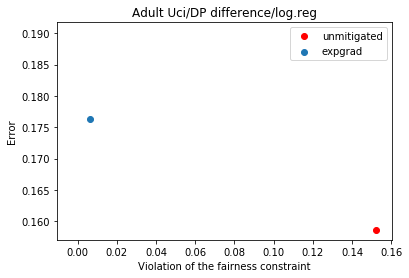

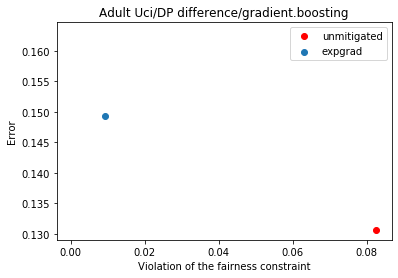

In [6]:
import matplotlib.pyplot as plt

plt.scatter(log_violation_expgrad,log_error_expgrad,label="expgrad")
plt.plot(log_violation_unmitigated, log_error_unmitigated,'ro',label="unmitigated")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/log.reg')
plt.legend()
plt.show()

plt.scatter(grad_violation_expgrad, grad_error_expgrad,label="expgrad")
plt.plot(grad_violation_unmitigated, grad_error_unmitigated,'ro',label="unmitigated")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/gradient.boosting')
plt.legend()
plt.show()

# Grid Search for Logistic Learner

### Using langrangian lambda derived from exponentiated gradient on complete dataset and predicting the value using predict from grid search

In [7]:
lambda_vecs_logistic = expgrad_X_logistic._lambda_vecs_lagrangian

In [8]:
grid_search_logistic=GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                        constraints=DemographicParity(),
                        grid=lambda_vecs_logistic)
a=datetime.now()
grid_search_logistic.fit(X_train_all, y_train_all, sensitive_features=A_train_all)
b=datetime.now()
log_time_grid_search = (b-a).seconds

In [9]:
def Qlog(X): return grid_search_logistic.predict(X)
# violation of log res
disparity_moment = DemographicParity()
disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
log_violation_grid_search = disparity_moment.gamma(Qlog).max()

# error of log res
error = ErrorRate()
error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
log_error_grid_search = error.gamma(Qlog)[0]

In [10]:
print('{}\t\t{}\t\t{}'.format('Type', 'Violation', 'Error'))
print('{}\t\t{}\t{}'.format('Unmit.', log_violation_unmitigated, log_error_unmitigated))
print('{}\t\t{}\t{}'.format('Expgrad', log_violation_expgrad, log_error_expgrad))
print('{}\t{}\t{}'.format('Grid Search', log_violation_grid_search, log_error_grid_search))

Type		Violation		Error
Unmit.		0.15237168667902207	0.1586253493443076
Expgrad		0.006127437339827541	0.17634941089714928
Grid Search	0.010536013405158834	0.17972420994441202


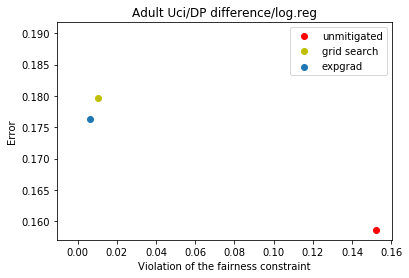

In [11]:
plt.scatter(log_violation_expgrad, log_error_expgrad, label="expgrad")
plt.plot(log_violation_unmitigated, log_error_unmitigated,'ro',label="unmitigated")
plt.plot(log_violation_grid_search, log_error_grid_search,'yo',label="grid search")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/log.reg')
plt.legend()
plt.show()

Type		Violation		Error
Grid Search	0.12424042105058944	0.1586253493443076
Grid Search	0.08306720544749827	0.16052946776818894
Grid Search	0.10317884433479604	0.15868677251927152
Grid Search	0.6692054912318417	0.49918614293172814
Grid Search	0.06275998299026853	0.16372347286631245
Grid Search	0.34388895052654667	0.3229630539602592
Grid Search	0.035152803520422146	0.1692515586130647
Grid Search	0.11682430974039112	0.21891219557138908
Grid Search	0.010536013405158834	0.17972420994441202
Grid Search	0.059102073532276894	0.16378489604127638
Grid Search	0.03339587888361546	0.17005005988759558
Grid Search	0.6152431106425984	0.4552685728325297
Selected GS	0.010536013405158834	0.17972420994441202
Exp.		0.006127437339827541	0.17634941089714928
Unmit.		0.15237168667902207	0.1586253493443076


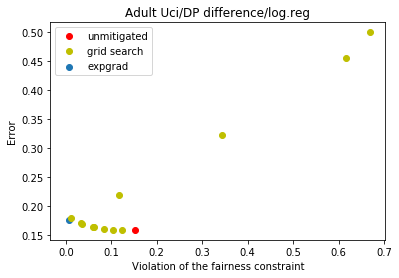

In [12]:
#all grid search predictors
predictors = grid_search_logistic._predictors

log_errors_all_gs = []
log_violation_all_gs = []
print('{}\t\t{}\t\t{}'.format('Type', 'Violation', 'Error'))
for i in predictors:
    def Qlog(X): return i.predict(X)
    # error of log res
    error = ErrorRate()
    error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
    e = error.gamma(Qlog)[0]
    log_errors_all_gs.append(e)

    # violation of log res
    disparity_moment = DemographicParity()
    disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
    v = disparity_moment.gamma(Qlog).max()
    log_violation_all_gs.append(v)
    
    print('{}\t{}\t{}'.format('Grid Search', v, e))
    
print('{}\t{}\t{}'.format('Selected GS', log_violation_grid_search, log_error_grid_search))
print('{}\t\t{}\t{}'.format('Exp.',log_violation_expgrad, log_error_expgrad))
print('{}\t\t{}\t{}'.format('Unmit.',log_violation_unmitigated, log_error_unmitigated))

plt.plot(log_violation_unmitigated, log_error_unmitigated,'ro',label="unmitigated")
plt.plot(log_violation_all_gs, log_errors_all_gs,'yo',label="grid search")
plt.scatter(log_violation_expgrad, log_error_expgrad, label="expgrad")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/log.reg')
plt.legend()
plt.show()

### Using langrangian lambda derived from exponentiated gradient on complete dataset and predicting the averaged error using pmf_predict

In [13]:
grid_search_logistic=GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                        constraints=DemographicParity(),
                        grid=lambda_vecs_logistic)
a=datetime.now()
grid_search_logistic.fit(X_train_all, y_train_all, sensitive_features=A_train_all)
b=datetime.now()
log_time_grid_search_pmf = (b-a).seconds

In [14]:
def _pmf_predict(X, predictors, weights):
    pred = pd.DataFrame()
    for t in range(len(predictors)):
        pred[t] = predictors[t].predict(X)
    positive_probs = pred[weights.index].dot(weights).to_frame()
    return np.concatenate((1-positive_probs, positive_probs), axis=1)

In [15]:
predictors = grid_search_logistic._predictors
weights_logistic = expgrad_X_logistic._weights

def Qlog(X): return _pmf_predict(X, predictors, weights_logistic)[:,1]
# violation of log res
disparity_moment = DemographicParity()
disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
log_violation_grid_search_pmf = disparity_moment.gamma(Qlog).max()

# error of log res
error = ErrorRate()
error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
log_error_grid_search_pmf = error.gamma(Qlog)[0]

In [16]:
print('{}\t\t{}\t\t{}'.format('Type', 'Violation', 'Error'))
print('{}\t\t{}\t{}'.format('Unmit.', log_violation_unmitigated, log_error_unmitigated))
print('{}\t\t{}\t{}'.format('Exp.', log_violation_expgrad, log_error_expgrad))
print('{}\t{}\t{}'.format('Grid Search pmf', log_violation_grid_search_pmf, log_error_grid_search_pmf))

Type		Violation		Error
Unmit.		0.15237168667902207	0.1586253493443076
Exp.		0.006127437339827541	0.17634941089714928
Grid Search pmf	0.00912312601497367	0.17539511199688723


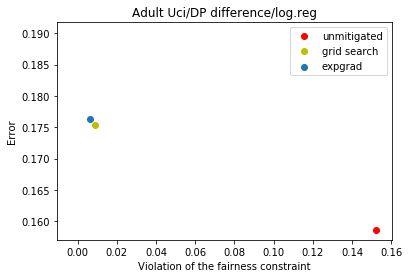

In [17]:
plt.scatter(log_violation_expgrad, log_error_expgrad, label="expgrad")
plt.plot(log_violation_unmitigated, log_error_unmitigated,'ro',label="unmitigated")
plt.plot(log_violation_grid_search_pmf, log_error_grid_search_pmf,'yo',label="grid search")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/log.reg')
plt.legend()
plt.show()

# Grid Search for Gradient Boosting

### Using langrangian lambda derived from exponentiated gradient on complete dataset and predicting the value using predict from grid search

In [18]:
lambda_vecs_ensemble = expgrad_X_ensemble._lambda_vecs_lagrangian

In [19]:
grid_search_ensemble=GridSearch(GradientBoostingClassifier(),
                        constraints=DemographicParity(),
                        grid=lambda_vecs_ensemble)
a=datetime.now()
grid_search_ensemble.fit(X_train_all, y_train_all, sensitive_features=A_train_all)
b=datetime.now()
grad_time_grid_search = (b-a).seconds

In [20]:
def Qgrad(X): return grid_search_ensemble.predict(X)
# violation of grad
disparity_moment = DemographicParity()
disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
grad_violation_grid_search = disparity_moment.gamma(Qlog).max()

# error of grad
error = ErrorRate()
error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
grad_error_grid_search = error.gamma(Qlog)[0]

In [21]:
print('{}\t\t{}\t\t{}'.format('Type', 'Violation', 'Error'))
print('{}\t\t{}\t{}'.format('Unmit.', grad_violation_unmitigated, grad_error_unmitigated))
print('{}\t\t{}\t{}'.format('Expgrad', grad_violation_expgrad, grad_error_expgrad))
print('{}\t{}\t{}'.format('Grid Search', grad_violation_grid_search, grad_error_grid_search))

Type		Violation		Error
Unmit.		0.08262975579420462	0.13064709314824483
Expgrad		0.0093279868188407	0.14926554930715014
Grid Search	0.00912312601497367	0.17539511199688723


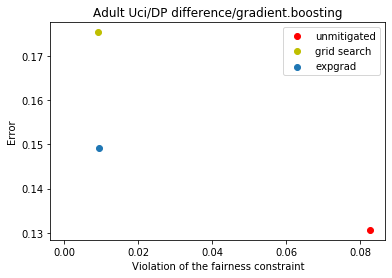

In [22]:
plt.scatter(grad_violation_expgrad, grad_error_expgrad,label="expgrad")
plt.plot(grad_violation_unmitigated, grad_error_unmitigated,'ro',label="unmitigated")
plt.plot(grad_violation_grid_search, grad_error_grid_search,'yo',label="grid search")

plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/gradient.boosting')
plt.legend()
plt.show()

Type		Violation		Error
Grid Search	0.11763440734082388	0.13064709314824483
Grid Search	0.08190845676707934	0.13178342188507725
Grid Search	0.10072808759668984	0.13107705537299222
Grid Search	0.6692054912318417	0.49918614293172814
Grid Search	0.057307172139953344	0.1353152544455023
Grid Search	0.08410736480148866	0.13162986394766746
Grid Search	0.584165105494303	0.4249562359878382
Grid Search	0.038354698226062384	0.14004483891772365
Grid Search	0.19859908798589246	0.23626424249869477
Grid Search	0.022347098016306605	0.14360738306563067
Grid Search	0.054305140838319	0.16934369337551058
Grid Search	0.013607939158928106	0.14591075212677743
Grid Search	0.6110684561284974	0.44227757132766193
Selected GS	0.00912312601497367	0.17539511199688723
Exp.		0.0093279868188407	0.14926554930715014
Unmit.		0.08262975579420462	0.13064709314824483


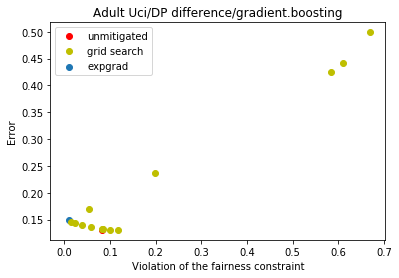

In [23]:
#all grid search predictors
predictors = grid_search_ensemble._predictors

grad_errors_all_gs = []
grad_violation_all_gs = []
print('{}\t\t{}\t\t{}'.format('Type', 'Violation', 'Error'))
for i in predictors:
    def Qlog(X): return i.predict(X)
    # error of log res
    error = ErrorRate()
    error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
    e = error.gamma(Qlog)[0]
    grad_errors_all_gs.append(e)

    # violation of log res
    disparity_moment = DemographicParity()
    disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
    v = disparity_moment.gamma(Qlog).max()
    grad_violation_all_gs.append(v)
    
    print('{}\t{}\t{}'.format('Grid Search', v, e))
    
print('{}\t{}\t{}'.format('Selected GS', grad_violation_grid_search, grad_error_grid_search))
print('{}\t\t{}\t{}'.format('Exp.',grad_violation_expgrad, grad_error_expgrad))
print('{}\t\t{}\t{}'.format('Unmit.',grad_violation_unmitigated, grad_error_unmitigated))

plt.plot(grad_violation_unmitigated, grad_error_unmitigated,'ro',label="unmitigated")
plt.plot(grad_violation_all_gs, grad_errors_all_gs,'yo',label="grid search")
plt.scatter(grad_violation_expgrad, grad_error_expgrad, label="expgrad")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/gradient.boosting')
plt.legend()
plt.show()

### Using langrangian lambda derived from exponentiated gradient on complete dataset and predicting the averaged error using pmf_predict

In [24]:
grid_search_ensemble=GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                        constraints=DemographicParity(),
                        grid=lambda_vecs_ensemble)
a=datetime.now()
grid_search_ensemble.fit(X_train_all, y_train_all, sensitive_features=A_train_all)
b=datetime.now()
grad_time_grid_search_pmf = (b-a).seconds

In [25]:
def _pmf_predict(X, predictors, weights):
    pred = pd.DataFrame()
    for t in range(len(predictors)):
        pred[t] = predictors[t].predict(X)
    positive_probs = pred[weights.index].dot(weights).to_frame()
    return np.concatenate((1-positive_probs, positive_probs), axis=1)

In [26]:
predictors = grid_search_ensemble._predictors
weights_ensemble = expgrad_X_ensemble._weights

def Qgrad(X): return _pmf_predict(X, predictors, weights_ensemble)[:,1]
# violation of log res
disparity_moment = DemographicParity()
disparity_moment.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
grad_violation_grid_search_pmf = disparity_moment.gamma(Qgrad).max()

# error of log res
error = ErrorRate()
error.load_data(X_train_all, y_train_all, sensitive_features=A_train_all)
grad_error_grid_search_pmf = error.gamma(Qgrad)[0]

In [27]:
print('{}\t\t{}\t\t{}'.format('Type', 'Violation', 'Error'))
print('{}\t\t{}\t{}'.format('Unmit.', grad_violation_unmitigated, grad_error_unmitigated))
print('{}\t\t{}\t{}'.format('Exp.', grad_violation_expgrad, grad_error_expgrad))
print('{}\t{}\t{}'.format('Grid Search pmf', grad_violation_grid_search_pmf, grad_error_grid_search_pmf))

Type		Violation		Error
Unmit.		0.08262975579420462	0.13064709314824483
Exp.		0.0093279868188407	0.14926554930715014
Grid Search pmf	0.032846996612059254	0.18746107323894123


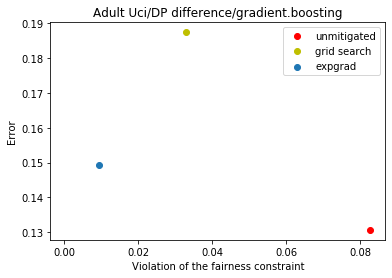

In [28]:
plt.scatter(grad_violation_expgrad, grad_error_expgrad, label="expgrad")
plt.plot(grad_violation_unmitigated, grad_error_unmitigated,'ro',label="unmitigated")
plt.plot(grad_violation_grid_search_pmf, grad_error_grid_search_pmf,'yo',label="grid search")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/gradient.boosting')
plt.legend()
plt.show()

# Error/Violation/Time Analysis

### Run exponential gradient on complete dataset

In [29]:
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import GridSearch, DemographicParity
import numpy as np

expgrad_error_logistic = []
expgrad_violation_logistic = []

expgrad_error_ensemble = []
expgrad_violation_ensemble = []

eps_list = [0.01]

for eps in eps_list:
    # Definition of expgrad for logistic learner
    expgrad_X_logistic = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=DemographicParity(),
    eps=eps,
    nu=1e-6)
    # Definition of expgrad for gradient boosting
    expgrad_X_ensemble = ExponentiatedGradient(
    GradientBoostingClassifier(),
    constraints=DemographicParity(),
    eps=eps,
    nu=1e-6)
    
    a=datetime.now()  
    expgrad_X_logistic.fit(
    X_train_all,
    y_train_all,
    sensitive_features=A_train_all)
    b=datetime.now()
    log_time_expgrad_all = (b-a).seconds
    
    a=datetime.now()  
    expgrad_X_ensemble.fit(
    X_train_all,
    y_train_all,
    sensitive_features=A_train_all)
    b=datetime.now()
    grad_time_expgrad_all = (b-a).seconds
    
    def Qlog(X): return expgrad_X_logistic._pmf_predict(X)[:, 1]
    # violation of log res
    disparity_moment = DemographicParity()
    disparity_moment.load_data(X, Y, sensitive_features=A)
    log_violation_expgrad_all = disparity_moment.gamma(Qlog).max()
    
    # error of log res
    error = ErrorRate()
    error.load_data(X, Y, sensitive_features=A)
    log_error_expgrad_all = error.gamma(Qlog)[0]
    
    def Qgrad(X): return expgrad_X_ensemble._pmf_predict(X)[:, 1]
    # violation of grad boost
    disparity_moment = DemographicParity()
    disparity_moment.load_data(X, Y, sensitive_features=A)
    grad_violation_expgrad_all = disparity_moment.gamma(Qgrad).max()
    
    # error of grad boost
    error = ErrorRate()
    error.load_data(X, Y, sensitive_features=A)
    grad_error_expgrad_all = error.gamma(Qgrad)[0]

### Results

In [30]:
print("Exponential Gradient on complete dataset")
print('{}\t\t{}\t\t{}\t\t\t{}'.format('Type', 'Violation', 'Error', 'Time'))
print("{}\t{}\t{}\t{}".format('Logistic', log_violation_expgrad_all, log_error_expgrad_all, log_time_expgrad_all))
print("{}\t{}\t{}\t{}".format('Grad boosting', grad_violation_expgrad_all, grad_error_expgrad_all, grad_time_expgrad_all))
print("")
print("Scaling method with 0.3 data subset:")
print("Logistic Learner: Time - {}".format(log_time_expgrad + log_time_grid_search))
print('{}\t\t{}\t\t{}\t\t\t{}'.format('Type', 'Violation', 'Error', 'Time'))
print('{}\t\t{}\t{}\t{}'.format('Exp.', log_violation_expgrad, log_error_expgrad, log_time_expgrad))
print('{}\t{}\t{}\t{}'.format('Selected GS', log_violation_grid_search, log_error_grid_search, log_time_grid_search))
print('{}\t{}\t{}\t{}'.format('Grid Search pmf', log_violation_grid_search_pmf, log_error_grid_search_pmf, log_time_grid_search))
print("")
print("Grad boosting learner - {}".format(grad_time_expgrad + grad_time_grid_search))
print('{}\t\t{}\t\t{}\t\t\t{}'.format('Type', 'Violation', 'Error', 'Time'))
print('{}\t\t{}\t{}\t{}'.format('Exp.',grad_violation_expgrad, grad_error_expgrad, grad_time_expgrad))
print('{}\t{}\t{}\t{}'.format('Selected GS', grad_violation_grid_search, grad_error_grid_search, grad_time_grid_search))
print('{}\t{}\t{}\t{}'.format('Grid Search pmf', grad_violation_grid_search_pmf, grad_error_grid_search_pmf, grad_time_grid_search))


Exponential Gradient on complete dataset
Type		Violation		Error			Time
Logistic	0.009999999999999842	0.17500405838194907	74
Grad boosting	0.009999999999999787	0.14616398371964864	77

Scaling method with 0.3 data subset:
Logistic Learner: Time - 67
Type		Violation		Error			Time
Exp.		0.006127437339827541	0.17634941089714928	35
Selected GS	0.010536013405158834	0.17972420994441202	32
Grid Search pmf	0.00912312601497367	0.17539511199688723	32

Grad boosting learner - 73
Type		Violation		Error			Time
Exp.		0.0093279868188407	0.14926554930715014	22
Selected GS	0.00912312601497367	0.17539511199688723	51
Grid Search pmf	0.032846996612059254	0.18746107323894123	51
